# Fraud Detection

In [ ]:
# Python GDS client
!pip install graphdatascience

In [ ]:
from graphdatascience import GraphDataScience

In [ ]:
# convenient graphing tool
import networkx as nx

In [ ]:
from neo4j import GraphDatabase, RoutingControl, basic_auth

In [ ]:
import pandas as pd
import numpy as np
import os

## Utilities

### Connect to DB

In [ ]:
# DB URI and authentication
URI = "bolt://localhost:7687"
AUTH = ("neo4j","p2p2p2p2")

In [ ]:
driver = GraphDatabase.driver(URI, auth=AUTH)

In [ ]:
driver.verify_connectivity()

In [ ]:
# template read request
def read_query(query, params={}):
    with driver.session(database="p2p") as session:
        results = session.execute_read(lambda tx: tx.run(query, params).data())       
        response = [record.values()[0] for record in results]
        return response

In [ ]:
# template write request
def write_query(query, params={}):
    with driver.session(database="p2p") as session:
        results = session.execute_write(lambda tx: tx.run(query, params).data())
        # response = [record.values()[0] for record in results]
        return results

In [ ]:
# template read with GDS into DataFramme
def read_gds(query, params=None):
    with driver.session(database="p2p") as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

## Explore Data

In [ ]:
# node counts
query = '''
    CALL apoc.meta.stats()
    YIELD labels
    UNWIND keys(labels) AS nodeLabel
    RETURN nodeLabel, labels[nodeLabel] AS nodeCount
'''

In [ ]:
response = read_gds(query)
response

In [ ]:
# relationship counts
query = '''
    CALL apoc.meta.stats()
    YIELD relTypesCount
    UNWIND keys(relTypesCount) AS relationshipType
    RETURN relationshipType, relTypesCount[relationshipType] AS relationshipCount
'''

In [ ]:
response = read_gds(query)
response

In [127]:
query = '''
    match (n:User {fraudMoneyTransfer:1})-[P2P]-(c:User) return n, c limit 100
    '''

In [128]:
# see in browser
response = read_gds(query)
response

,n,c
0,"(fraudRisk, p2pReceivedWeightedPageRank, wccId...","(fraudRisk, p2pReceivedWeightedPageRank, fraud..."
1,"(fraudRisk, p2pReceivedWeightedPageRank, wccId...","(fraudRisk, p2pReceivedWeightedPageRank, fraud..."
2,"(fraudRisk, p2pReceivedWeightedPageRank, wccId...","(fraudRisk, p2pReceivedWeightedPageRank, fraud..."
3,"(fraudRisk, p2pReceivedWeightedPageRank, wccId...","(fraudRisk, p2pReceivedWeightedPageRank, fraud..."
4,"(fraudRisk, p2pReceivedWeightedPageRank, wccId...","(fraudRisk, p2pReceivedWeightedPageRank, fraud..."
...,...,...
95,"(fraudRisk, p2pReceivedWeightedPageRank, wccId...","(fraudRisk, p2pReceivedWeightedPageRank, fraud..."
96,"(fraudRisk, p2pReceivedWeightedPageRank, wccId...","(fraudRisk, p2pReceivedWeightedPageRank, fraud..."
97,"(fraudRisk, p2pReceivedWeightedPageRank, wccId...","(fraudRisk, p2pReceivedWeightedPageRank, fraud..."
98,"(fraudRisk, p2pReceivedWeightedPageRank, wccId...","(fraudRisk, p2pReceivedWeightedPageRank, fraud..."


## Query the Database

### GDS Execution Modes

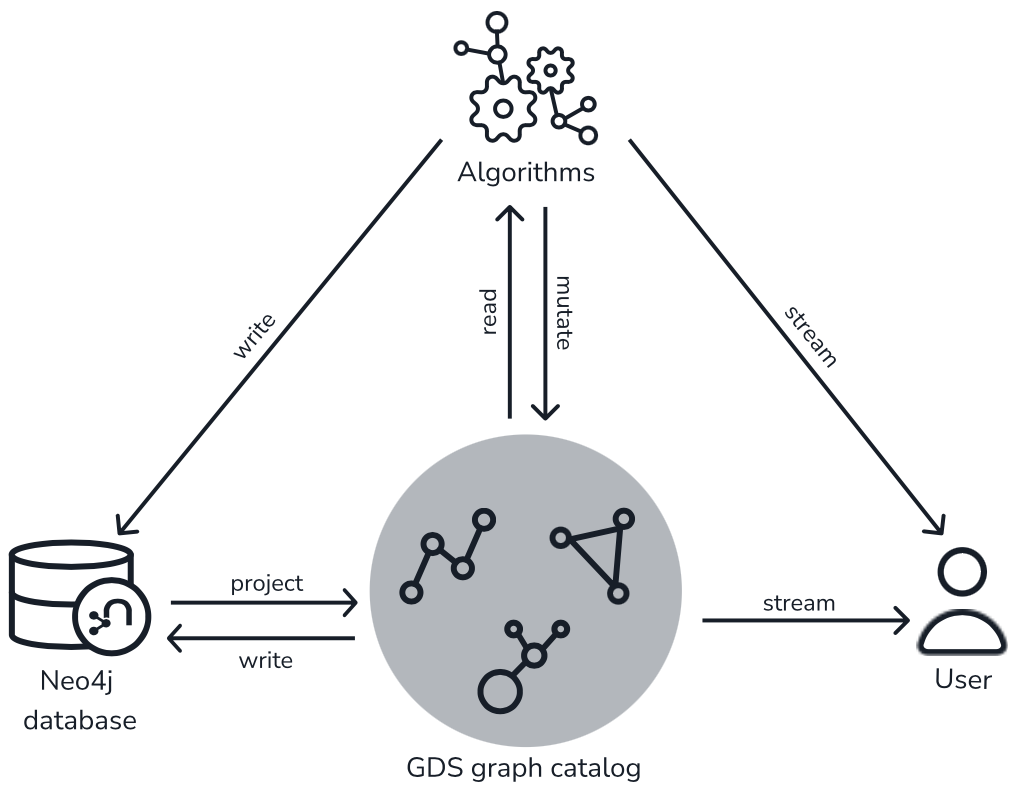{width=40%}{height=250px}

In [ ]:
gds = GraphDataScience(URI, AUTH, database="p2p")

In [ ]:
# Model of running algorithms
CALL gds[.<tier>].<algorithm>.<execution-mode>[.<estimate>](
  graphName: String,
  configuration: Map
)

In [ ]:
# Clean exixting projections
def clear_graph_by_name(g_name):
    if gds.graph.exists(g_name).exists:
        gds.graph.get(g_name).drop()

def clear_all_graphs():
    g_names = gds.graph.list().graphName.tolist()
    for g_name in g_names:
        gds.graph.get(g_name).drop()

In [ ]:
# fraud money transfer flags
gds.run_cypher('MATCH(u:User) RETURN u.fraudMoneyTransfer AS fraud, count(u) AS cnt')

### Search for Patterns - Communities

In [ ]:
# clear the graph if it exists beforehand
clear_graph_by_name('proj')

In [ ]:
# create a projection
query = """
    CALL gds.graph.project('dop', 
        'Character', 'INTERACTS')      
"""

In [ ]:
# create a graph object g - a memory projection
g, meta = gds.graph.project('proj', 
                            ['User', 'Card', 'Device'], 
                            {'HAS_CC': {'orientation': 'UNDIRECTED'},
                             'USED': {'orientation': 'UNDIRECTED'},
                             'AGGREGATED_P2P': {'type':'P2P', 'orientation': 'NATURAL',
                                'properties': {'numberOfTransactions':{'property': '*', 'aggregation': 'COUNT'}}}})

In [ ]:
meta

In [53]:
# run Louvain algorithm to detect comunitiesand create a new property
result = gds.louvain.write(g, writeProperty='louvainCommunityId')

In [56]:
# observe the new flag
gds.run_cypher('MATCH(u:User) RETURN u.louvainCommunityId AS community, count(u) AS cnt')

,community,cnt
0,170803,815
1,170271,2
2,174914,4
3,170273,2
4,34703,4
...,...,...
11663,203963,1
11664,203966,1
11665,106046,1
11666,41585,1


In [58]:
# Louvain communities ordered by number of frauds
gds.run_cypher('''
    MATCH (u:User)
    WITH u.louvainCommunityId AS communityId,
        count(u) AS userCount,
        sum(u.fraudMoneyTransfer) as flaggedCount
    RETURN communityId,
        userCount,
        flaggedCount,
        toFloat(flaggedCount)/toFloat(userCount) AS flaggedRatio
    ORDER BY flaggedCount DESC LIMIT 100
''')

,communityId,userCount,flaggedCount,flaggedRatio
0,25771,149,7,0.046980
1,182733,7,4,0.571429
2,35239,7,3,0.428571
3,176956,3,3,1.000000
4,173038,229,3,0.013100
...,...,...,...,...
95,5799,4,1,0.250000
96,180420,61,1,0.016393
97,185933,141,1,0.007092
98,174011,20,1,0.050000


In [67]:
params = {"id": "5799"}

In [ ]:
# run in browser
query = '''
    MATCH(u1:User{louvainCommunityId: $id})-[r1:HAS_CC|HAS_IP|USED]->(n)<-[r2:HAS_CC|HAS_IP|USED]-(u2:User{louvainCommunityId: $id})
    WITH *
    OPTIONAL MATCH (u1)-[r3:P2P]-(u2)
    RETURN *
'''

In [69]:
# run in browser
query = '''   
    MATCH(n1 {louvainCommunityId: $id})
    MATCH(n2 {louvainCommunityId: $id})
    WITH *
    OPTIONAL MATCH (n1)-[r]-(n2)
    RETURN *
'''

In [70]:
# Count use of shared card and create a new link P2P_WITH_SHARED_CARD for it
gds.run_cypher('''
    MATCH (u1:User)-[r:P2P]->(u2)
    WITH u1, u2, count(r) AS cnt
    MATCH (u1)-[:HAS_CC]->(n)<-[:HAS_CC]-(u2)
    WITH u1, u2, count(DISTINCT n) AS cnt
    MERGE(u1)-[s:P2P_WITH_SHARED_CARD]->(u2)
    RETURN count(DISTINCT s) AS cnt
''')

,cnt
0,6240


In [77]:
clear_graph_by_name('proj')

In [78]:
# Investigate and label the transactions with shared cards
g, meta = gds.graph.project('proj', 
                            ['User'], {'P2P_WITH_SHARED_CARD': {'orientation': 'UNDIRECTED'}})

In [79]:
# Create new property for Weakly Connected Components (WCC) - separate subgraphs
df = gds.wcc.write(g, writeProperty='wccId')
g.drop()

graphName                                                             proj
database                                                               p2p
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                            33732
relationshipCount                                                    12480
configuration            {'relationshipProjection': {'P2P_WITH_SHARED_C...
density                                                           0.000011
creationTime                           2024-04-25T00:50:39.330951000+00:00
modificationTime                       2024-04-25T00:50:39.463954000+00:00
schema                   {'graphProperties': {}, 'nodes': {'User': {}},...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'User': {}},...
Name: 0, dtype: object

In [81]:
gds.run_cypher('''
    MATCH (u:User) WHERE NOT u:FraudRiskUser
    SET u.fraudRisk=0
''')

""


## Predict Fraud Risk Accounts

In [82]:
# Mark communities
gds.run_cypher('''
    MATCH (u:User)
    WITH u.wccId AS componentId, count(*) AS communitySize, collect(u) AS users
    WITH communitySize, toInteger(communitySize > 1) AS partOfCommunity, users
    UNWIND users as u
    SET u.communitySize = communitySize
    SET u.partOfCommunity = partOfCommunity;
''')

""


In [98]:
# Card-sharing centrality detection
# clear the graph if it exists beforehand
clear_graph_by_name('p2p-features')

#project
g, meta = gds.graph.project('p2p-features', 
          ['User'], 
          {'P2P': {'type': 'P2P', 'orientation': 'NATURAL', 'aggregation': 'SUM', 'properties': ['totalAmount']},
           'P2P_REVERSE': {'type': 'P2P', 'orientation': 'REVERSE', 'aggregation': 'SUM', 'properties': ['totalAmount']},
           'P2P_WITH_SHARED_CARD': {'type': 'P2P_WITH_SHARED_CARD', 'orientation': 'NATURAL'}
})


In [84]:
# shared card pageRank (influence)
gds.pageRank.write(g, relationshipTypes=['P2P_WITH_SHARED_CARD'], maxIterations=1000,
                   writeProperty='p2pSharedCardPageRank')

writeMillis                                                             179
nodePropertiesWritten                                                 33732
ranIterations                                                            97
didConverge                                                            True
centralityDistribution    {'min': 0.14999961853027344, 'max': 3.37539577...
postProcessingMillis                                                     31
preProcessingMillis                                                       0
computeMillis                                                           414
configuration             {'writeProperty': 'p2pSharedCardPageRank', 'jo...
Name: 0, dtype: object

In [85]:
# pageRank of P2P sender and receiver 
gds.pageRank.write(g, relationshipTypes=['P2P'], maxIterations=1000, writeProperty='p2pSentPageRank')

writeMillis                                                             203
nodePropertiesWritten                                                 33732
ranIterations                                                           103
didConverge                                                            True
centralityDistribution    {'min': 0.14999961853027344, 'max': 28.1669912...
postProcessingMillis                                                     39
preProcessingMillis                                                       0
computeMillis                                                           325
configuration             {'writeProperty': 'p2pSentPageRank', 'jobId': ...
Name: 0, dtype: object

In [99]:
# P2P receiver pageRank
gds.pageRank.write(g, relationshipTypes=['P2P_REVERSE'], maxIterations=1000, relationshipWeightProperty='totalAmount',
                   writeProperty='p2pReceivedWeightedPageRank')

writeMillis                                                             157
nodePropertiesWritten                                                 33732
ranIterations                                                           112
didConverge                                                            True
centralityDistribution    {'min': 0.14999961853027344, 'max': 501.640624...
postProcessingMillis                                                     56
preProcessingMillis                                                       0
computeMillis                                                           358
configuration             {'writeProperty': 'p2pReceivedWeightedPageRank...
Name: 0, dtype: object

In [86]:
# P2P receiver with weighted degree centrality
gds.degree.write(g, relationshipTypes=['P2P_REVERSE'], relationshipWeightProperty='totalAmount',
                 writeProperty='p2pReceivedWeightedDegree')

nodePropertiesWritten                                                 33732
writeMillis                                                             135
centralityDistribution    {'min': 0.0, 'max': 498911.9999694824, 'p90': ...
postProcessingMillis                                                    306
preProcessingMillis                                                       0
computeMillis                                                            12
configuration             {'writeProperty': 'p2pReceivedWeightedDegree',...
Name: 0, dtype: object

In [87]:
g.drop()

graphName                                                     p2p-features
database                                                               p2p
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                            33732
relationshipCount                                                    92510
configuration            {'relationshipProjection': {'P2P_WITH_SHARED_C...
density                                                           0.000081
creationTime                           2024-04-25T01:06:12.305628000+00:00
modificationTime                       2024-04-25T01:06:12.511003000+00:00
schema                   {'graphProperties': {}, 'nodes': {'User': {}},...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'User': {}},...
Name: 0, dtype: object

### Centrality of Individuals

In [88]:
# clear the graph if it exists beforehand
clear_graph_by_name('p2p-features')

#project
g, meta = gds.graph.project('user-centrality-features', 
                            ['User', 'Card', 'Device', 'IP'], 
                            ['HAS_CC', 'HAS_IP', 'USED'])

In [89]:
# card count/degree
gds.degree.mutate(g, nodeLabels=['User', 'Card'], relationshipTypes=['HAS_CC'], mutateProperty='cardDegree')

# device count/degree
gds.degree.mutate(g, nodeLabels=['User', 'Device'], relationshipTypes=['USED'], mutateProperty='deviceDegree')

# IP count/degree
gds.degree.mutate(g, nodeLabels=['User', 'IP'], relationshipTypes=['HAS_IP'], mutateProperty='ipDegree')

nodePropertiesWritten                                                619587
mutateMillis                                                              0
centralityDistribution    {'min': 0.0, 'max': 849.0038986206055, 'p90': ...
postProcessingMillis                                                      0
preProcessingMillis                                                       0
computeMillis                                                            50
configuration             {'orientation': 'NATURAL', 'mutateProperty': '...
Name: 0, dtype: object

In [90]:
# write node properties
gds.graph.writeNodeProperties(g, ['cardDegree', 'deviceDegree', 'ipDegree'], ['User'])

writeMillis                                           336
graphName                        user-centrality-features
nodeProperties       [cardDegree, deviceDegree, ipDegree]
propertiesWritten                                  101196
Name: 0, dtype: object

In [91]:
g.drop()

graphName                                         user-centrality-features
database                                                               p2p
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                           789856
relationshipCount                                                  1672041
configuration            {'relationshipProjection': {'HAS_IP': {'aggreg...
density                                                           0.000003
creationTime                           2024-04-25T01:25:30.700030000+00:00
modificationTime                       2024-04-25T01:26:03.350268000+00:00
schema                   {'graphProperties': {}, 'nodes': {'User': {'de...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'User': {'de...
Name: 0, dtype: object

## Machine Learning for Predicting the Risk of Fraud

### Data of Users With the Assigned Features

In [92]:
df = gds.run_cypher('''
    MATCH(u:User)
    RETURN u.guid AS guid,
        u.wccId AS wccId,
        u.fraudRisk AS fraudRisk,
        u.fraudMoneyTransfer AS fraudMoneyTransfer,
        u.p2pSharedCardPageRank AS p2pSharedCardPageRank,
        u.p2pSentPageRank AS p2pSentPageRank,
        u.p2pReceivedWeightedPageRank AS p2pReceivedWeightedPageRank,
        u.p2pReceivedWeightedDegree AS p2pReceivedWeightedDegree,
        u.ipDegree AS ipDegree,
        u.cardDegree AS cardDegree,
        u.deviceDegree AS deviceDegree,
        u.communitySize AS communitySize,
        u.partOfCommunity AS partOfCommunity
''')
df

,guid,wccId,fraudRisk,fraudMoneyTransfer,p2pSharedCardPageRank,p2pSentPageRank,p2pReceivedWeightedPageRank,p2pReceivedWeightedDegree,ipDegree,cardDegree,deviceDegree,communitySize,partOfCommunity
0,be0222d26897046dc92ae2929d3427e7,0,0,0,0.150000,0.175456,None,10.0,21.0,3.0,4.0,1,0
1,59515432f0e2e79b83e9524c94f7f86e,1,0,0,0.150000,0.310548,None,10.0,7.0,1.0,1.0,1,0
2,ba1f4324c66ee093478d41a6826a3649,2,0,0,0.150000,0.277500,None,160.0,8.0,2.0,1.0,1,0
3,8a18e1625e35a9f66abfd7bd2d04f0b3,3,0,0,0.150000,0.230174,None,100.0,135.0,12.0,2.0,1,0
4,9f705a0107acc25a57f9e6aa8436a08e,4,0,0,0.150000,0.391426,None,2703.6,169.0,9.0,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33727,f3693169dcc9064114a171c5c2f485b5,33727,0,0,0.150000,0.297005,None,5.0,14.0,2.0,2.0,1,0
33728,10f7f048645c602de3fae7c2cf81b254,27913,0,0,0.999999,0.371382,None,150.0,5.0,4.0,4.0,2,1
33729,d3a4469957800636802a8de4874af1bc,33729,0,0,0.150000,0.150000,None,0.0,38.0,2.0,0.0,1,0
33730,4698ccb2e4b07b1974741f634115e49b,33730,0,0,0.150000,0.181054,None,10.0,1.0,1.0,0.0,1,0


In [101]:
df.isnull().sum()

guid                               0
wccId                              0
fraudRisk                          0
fraudMoneyTransfer                 0
p2pSharedCardPageRank              0
p2pSentPageRank                    0
p2pReceivedWeightedPageRank    33732
p2pReceivedWeightedDegree          0
ipDegree                           0
cardDegree                         0
deviceDegree                       0
communitySize                      0
partOfCommunity                    0
dtype: int64

In [102]:
# Redesign and split into X and y
X = df.drop(columns=['fraudRisk', 'fraudMoneyTransfer', 'wccId', 'guid', 'p2pReceivedWeightedPageRank'])
y = df.fraudRisk - df.fraudMoneyTransfer

### Train and Test

In [103]:
# Split in train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [104]:
# Train with Random Forest Algorithm
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, random_state=0, max_depth=5, bootstrap=True, class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=500,
                       random_state=0)

### Accuracy

In [107]:
clf.score(X_train, y_train)

0.8175653140633685

In [108]:
# Test with the Test Data Set
clf.score(X_test, y_test)

0.8219949607232844

In [138]:
y_predict = clf.predict(X_test)

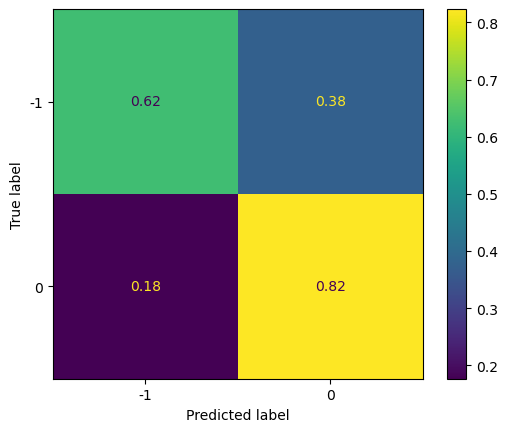

In [114]:
# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_predict, display_labels=clf.classes_, 
                                             normalize='true', colorbar=True)

### Visualisation of the Accuracy

Text(0.5, 1.0, 'ROC Curve')

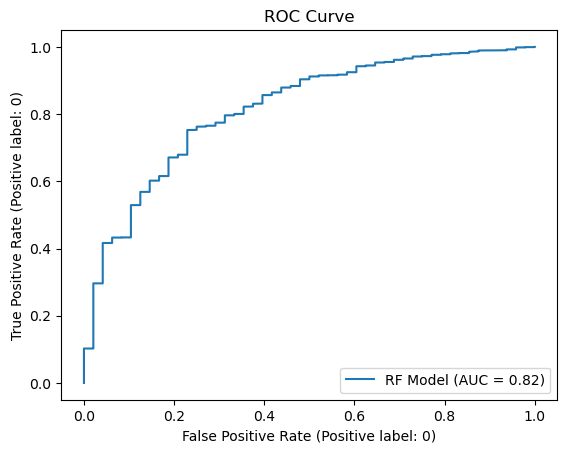

In [115]:
from sklearn.metrics import RocCurveDisplay
display = RocCurveDisplay.from_estimator(clf, X_test, y_test, name="RF Model")
display.ax_.set_title("ROC Curve")

In [119]:
# Get the most important features for the claassification
def feature_importance(columns, classifier):
    features = list(zip(columns, classifier.feature_importances_))
    sorted_features = sorted(features, key = lambda x: x[1]*-1)

    keys = [value[0] for value in sorted_features]
    values = [value[1] for value in sorted_features]
    return pd.DataFrame(data={'feature': keys, 'importance': values})

In [120]:
feature_importance(X_train.columns, clf)

,feature,importance
0,cardDegree,0.298836
1,p2pReceivedWeightedDegree,0.190206
2,p2pSentPageRank,0.181384
3,ipDegree,0.108104
4,communitySize,0.068553
5,deviceDegree,0.061462
6,partOfCommunity,0.052072
7,p2pSharedCardPageRank,0.039383


Now we can investigate further the predictions in the Neo4j browser.

### Predict Unlabeled Users

### Store the Model

In [122]:
# from sklearn.externals import joblib
import joblib
joblib.dump(clf, '../data/clfmodel.pkl')

['../data/clfmodel.pkl']

### Clean All

In [ ]:
# delete created relationships
gds.run_cypher('MATCH (:User)-[r:P2P_WITH_SHARED_CARD]->() DELETE r')
gds.run_cypher('MATCH (:User)-[r:AGGREGATED_P2P]->() DELETE r')
gds.run_cypher('MATCH (:User)-[r:AGGREGATED_P2P]->() DELETE r')

In [ ]:
# remove created node Labels
gds.run_cypher('MATCH (u:FlaggedUser) REMOVE u:FlaggedUser')
gds.run_cypher('MATCH (u:FraudRiskUser) REMOVE u:FraudRiskUser')
gds.run_cypher('MATCH (u:FraudSharedId) REMOVE u:FraudSharedId')
gds.run_cypher('MATCH (u:PredictedFraudRisk) REMOVE u:PredictedFraudRisk')

In [ ]:
# remove created node properties
gds.run_cypher('''
    MATCH (n)
    REMOVE n.wccId,
        n.sharedIdsDegree,
        n.predictedProbability,
        n.partOfCommunity,
        n.p2pSharedCardPageRank,
        n.p2pSharedCardDegree,
        n.p2pSentWeightedPageRank,
        n.p2pSentPageRank,
        n.p2pSentDegree,
        n.p2pReversedSharedCardPageRank,
        n.p2pReversedSharedCardDegree,
        n.p2pReceivedWeightedPageRank,
        n.p2pReceivedWeightedDegree,
        n.p2pReceivedPageRank,
        n.p2pReceivedDegree,
        n.louvainCommunityId,
        n.ipDegree,
        n.fraudRiskRatio,
        n.fraudRiskDegree,
        n.fraudRisk,
        n.flaggedRatio,
        n.flaggedDegree,
        n.deviceDegree,
        n.degree,
        n.communitySize,
        n.cardDegree
''')

## Reference
p2p: https://www.westernunion.com/blog/en/gb/what-is-a-p2p-payment-system-how-does-it-work/<br>
data: https://drive.google.com/drive/folders/1LaNFObKnZb1Ty8T7kPLCYlXDUlHU7FGa <br>
blog:https://neo4j.com/developer-blog/exploring-fraud-detection-neo4j-graph-data-science-summary/ <br>
code examples: https://github.com/neo4j-product-examples/demo-fraud-detection-with-p2p <br>